# Imports

In [11]:
from scipy import signal
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from glob import glob
import random

# Q1 : Intensity window-based correlation

In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,_ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),3,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),3,color,-1)
    return img1,img2

def draw_matches(image, matches, window_size, draw_lines = False):
    h, w, _ = image.shape

    image2 = image.copy()
    
    for match in matches:
        color = tuple(np.random.randint(0,255,3).tolist())
        start = (int(match[1] + window_size//2), int(match[0] + window_size//2))        
        end   = (int(match[3] + window_size//2 + w//2), int(match[2] + window_size//2))
        if draw_lines:
            image2 = cv2.line(image2, start, end, color, 2)
        image2 = cv2.circle(image2,start,2,(0, 0, 0),-1)
        image2 = cv2.circle(image2,start,1,color,-1)
        image2 = cv2.circle(image2,end,2,(0, 0, 0),-1)
        image2 = cv2.circle(image2,end,1,color,-1)
    return image2

def cross_corr(image1, image2):
    image1 = image1 - image1.mean()
    image2 = image2 - image2.mean()
    
    # Calculate the Normalised Cross Correlation
    n_corr = np.sum(image1*image2) / np.sqrt( np.sum(image1**2) * np.sum(image2**2))
    
    return n_corr

In [13]:
def gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def patch_correlation_matching(image1, image2, window_size, stride):
    # Get the shape of the input images
    h1, w1 = image1.shape
    h2, w2 = image2.shape

    matches = np.zeros((0,4))
    for i in range(0, h1-window_size, stride):
        for j in range(0, w1-window_size, stride):
            
            query_patch = image1[i:i+window_size, j:j+window_size]         # Extract the query patch

            best_n_corr = -9999999
            best_match = (0,0)
            for ii in range(0, h2-window_size, stride):
                for jj in range(0, w2-window_size, stride):
                    # Extract patch
                    patch = image2[ii:ii+window_size, jj:jj+window_size]

                    n_corr = cross_corr(query_patch, patch)                # Perform Normalised Cross Correlation

                    # If Normalised Cross Correlation value if higher than the current best then update
                    if n_corr > best_n_corr:
                        best_n_corr = n_corr
                        best_match = (ii, jj)
                        
            matches = np.concatenate((matches,np.array([[i, j, best_match[0], best_match[1]]])), axis=0)
    return matches

In [16]:
def M1(im,im1,im2):
    h, w = gray(im).shape
    left_image = im1      
    right_image = im2

    matches = patch_correlation_matching(gray(left_image), gray(right_image), window_size=32, stride=32)
    fig3 = plt.figure(constrained_layout=True,figsize=(10, 10))
    plt.imshow(draw_matches(im, matches, 16, draw_lines=True))
    plt.title("Matches")

<ipython-input-12-5dc17f872615>:36: RuntimeWarning: invalid value encountered in double_scalars
  n_corr = np.sum(image1*image2) / np.sqrt( np.sum(image1**2) * np.sum(image2**2))


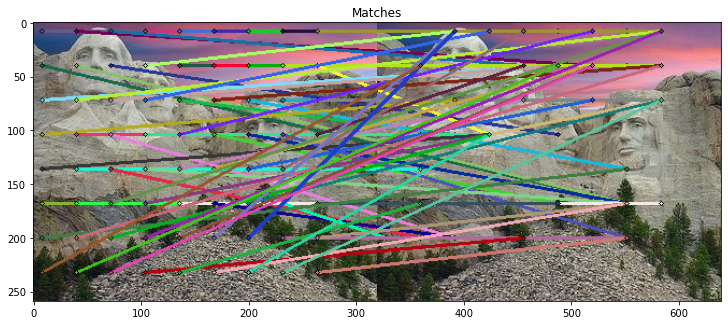

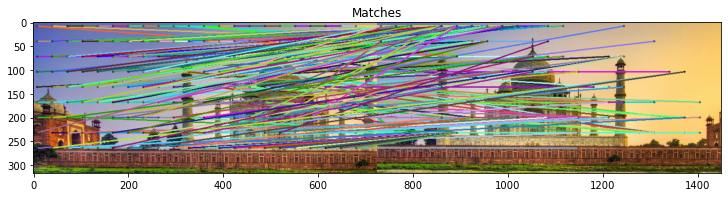

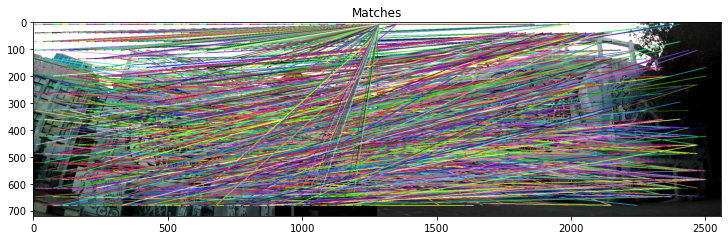

In [17]:
images = []
im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
images.append(im)
M1(im,im1,im2)
im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_1.png"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_2.png"), cv2.COLOR_BGR2RGB)
cm = cv2.resize(im2, (725, 317), 
               interpolation = cv2.INTER_NEAREST)
im = cv2.hconcat([im1,cm])
images.append(im)
M1(im,im1,cm)
im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
images.append(im)
M1(im,im1,im2)

# Q2 : Select few points in the first image and then plot their corresponding epipolar lines on the second

In [18]:
def Flan_mat(des1,des2):
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    return flann, matches

def sift_matching_RANSAC(img1,img2,min_match_cnt=500,match_th =0.8):
    '''
    Returns correspondings points in the two images and the fundamental axis using best SIFT features as correspondances to find the fundamental matrix
    '''
    sift = cv2.SIFT_create()
    h,w,c = img1.shape
    kp=[]
    for i in range(1,h,10):
        for j in range(1,w,10):
            kp.append(cv2.KeyPoint(i, j, 3))
    kp1,des1 = sift.compute(gray(img1),kp)
    kp2,des2 = sift.compute(gray(img2),kp)
    
    flann, matches = Flan_mat(des1,des2)
    
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < match_th*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC)
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return pts1,pts2,F

def epipolar_lines(pt, img, F):
    _,N = pt.shape
    if img==1:
        line = F @ pt
    else:
        line = (F.T)@ pt
    norm = np.zeros((1,N))
    s =line.copy()
    norm = np.sum((line[:2,:])**2, axis = 0)
    line = line/(np.tile(norm, (3, 1)))   
    return line


def to_homo(pts):
    at = cv2.convertPointsToHomogeneous(pts)
    return at


In [19]:
def Q2(img1,img2):
    pts1, pts2, F = sift_matching_RANSAC (img1,img2)
    pts2_norm = to_homo(pts2)
    pts1_norm = to_homo(pts1)

    lines1 = epipolar_lines(np.squeeze(pts2_norm, axis=1).T, 2,F)
    lines2 = epipolar_lines(np.squeeze(pts1_norm, axis=1).T, 1,F)

    img5,img6 = drawlines(img1,img2,lines1.T,pts1,pts2)
    img3,img4 = drawlines(img2,img1,lines2.T,pts2,pts1)

    plt.figure(figsize = [15,20])
    plt.subplot(121),plt.imshow(img5)
    plt.title("Image 1")
    plt.axis('off')
    plt.subplot(122),plt.imshow(img3)
    plt.title("Image 2")
    plt.axis('off')
    plt.show()

<ipython-input-12-5dc17f872615>:10: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img1 = cv2.circle(img1,tuple(pt1),3,color,-1)
<ipython-input-12-5dc17f872615>:11: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img2 = cv2.circle(img2,tuple(pt2),3,color,-1)


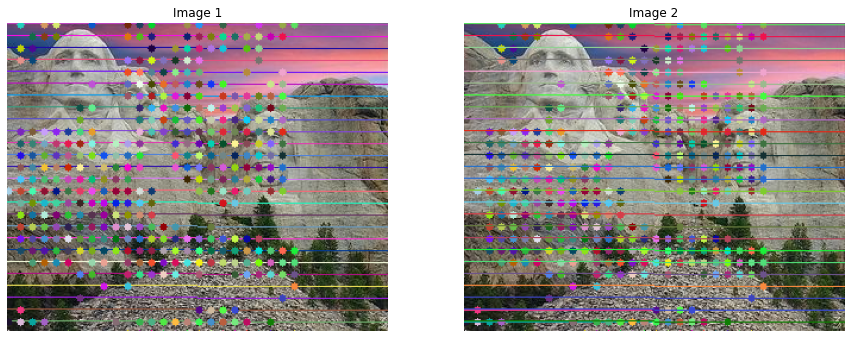

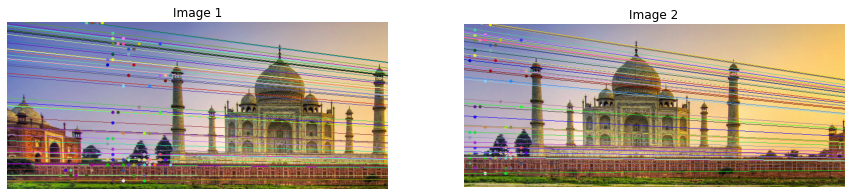

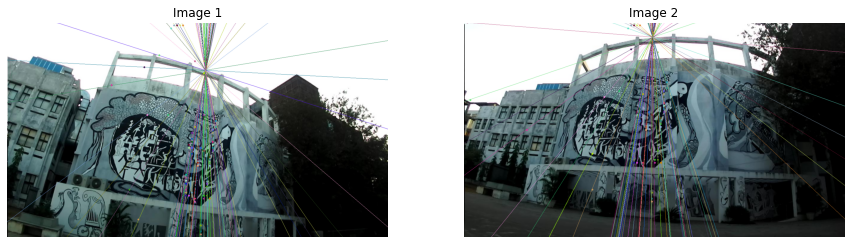

In [20]:
img1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_2.jpg"), cv2.COLOR_BGR2RGB)
Q2(img1,img2)
img1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_1.png"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_2.png"), cv2.COLOR_BGR2RGB)
Q2(img1,img2)
img1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_2.jpg"), cv2.COLOR_BGR2RGB)
Q2(img1,img2)

# Q3 : Rectify the pair of images and on these new images, find the correspondences using greedy matching.

In [25]:
def stereo_rectification(image1, image2, nfeatures=500):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    kp1, desc1 = sift.detectAndCompute(image1, None)    
    kp2, desc2 = sift.detectAndCompute(image2, None)

    matches = bf.match(desc1, desc2) 

    matches = sorted(matches, key = lambda x:x.distance)[:50]

    x = np.float32(np.array([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2))
    xs = np.float32(np.array([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2))

    F, mask = cv2.findFundamentalMat(x, xs, cv2.FM_RANSAC, 0.1)

    x = x[mask.ravel() == 1]
    xs = xs[mask.ravel() == 1]

    ret, H1, H2 = cv2.stereoRectifyUncalibrated(x, xs, F, image1.shape[0:2])
    if ret:
        image1_rectified = cv2.warpPerspective(image1, H1, (image1.shape[1], image1.shape[0]))
        image2_rectified = cv2.warpPerspective(image2, H2, (image2.shape[1], image2.shape[0]))

    return image1_rectified, image2_rectified, x, xs, F, H1, H2

In [26]:
def stereo_correspondance_greedy(image_left, image_right, window_size, stride):
    # Get the shape of the input images
    h1, w1 = image_left.shape
    h2, w2 = image_right.shape

    matches = np.zeros((0,4))

    # Loop over the first image to generate query patches
    for i in range(0, h1-window_size, stride):
        for j in range(0, w1-window_size, stride):
            # Extract the query patch
            query_patch = image_left[i:i+window_size, j:j+window_size]

            best_n_corr = -9999999
            best_match = (0,0)
            ii = i
            for jj in range(0, w2-window_size, stride):
                # Extract patch
                patch = image_right[ii:ii+window_size, jj:jj+window_size]

                # Perform Normalised Cross Correlation
                n_corr = cross_corr(query_patch, patch)
                # n_corr = corr(query_patch.flatten(), patch.flatten())

                # If Normalised Cross Correlation value if higher than the current best then update
                if n_corr > best_n_corr:
                    best_n_corr = n_corr
                    best_match = (ii, jj)

            # Best Match for the current query patch            
            matches = np.concatenate((matches,np.array([[i, j, best_match[0], best_match[1]]])), axis=0)
    return matches

In [27]:
def M3(img,img1,img2,is_rectified=False):
        h, w = gray(img).shape
        
        if is_rectified:
            left_image, right_image, x, xs, F, H1, H2 = stereo_rectification(img1,img2)
            img2 = np.zeros((h,w,3)).astype('uint8')
            img2[0:h, 0:w//2,:] = left_image
            img2[0:h,w//2:,:] = right_image
            img = img2

        matches = stereo_correspondance_greedy(gray(img1), gray(img2), 32, 32)
        fig3 = plt.figure(constrained_layout=True,figsize=(10, 10))
        plt.imshow(draw_matches(img, matches, 16, draw_lines=True))
        plt.title("Matches")       

<ipython-input-12-5dc17f872615>:36: RuntimeWarning: invalid value encountered in double_scalars
  n_corr = np.sum(image1*image2) / np.sqrt( np.sum(image1**2) * np.sum(image2**2))


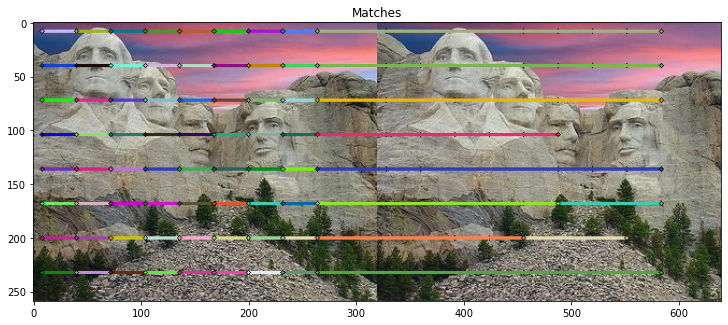

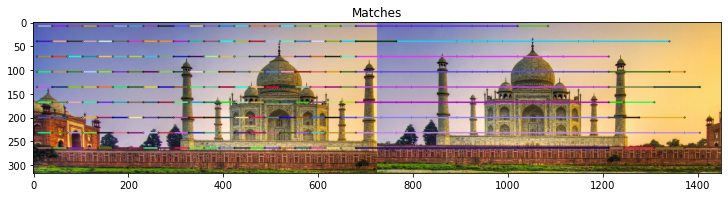

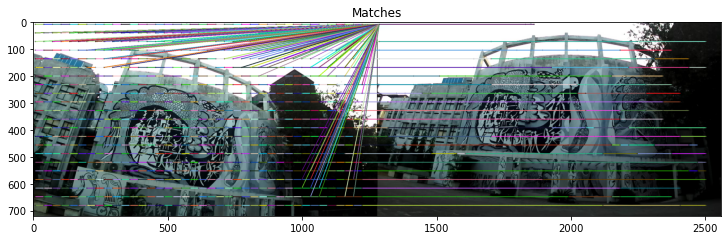

In [28]:
im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
M3(im,im1,im2)

im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_1.png"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_2.png"), cv2.COLOR_BGR2RGB)
cm = cv2.resize(im2, (725, 317), 
               interpolation = cv2.INTER_NEAREST)
im = cv2.hconcat([im1,cm])
M3(im,im1,cm)

im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
M3(im,im1,im2)

# Bonus : SIFT

In [35]:
def M4(img,img1,img2):
        h, w = gray(img).shape
        
        matches_window = patch_correlation_matching(gray(img1), gray(img2), window_size=32, stride=32)
        
        sift = cv2.xfeatures2d.SIFT_create(nfeatures=500)
        # Create BF Matcher
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
        # Find keypoints and descriptors 
        kp1, desc1 = sift.detectAndCompute(img1, None)    
        kp2, desc2 = sift.detectAndCompute(img2, None)
        # Match descriptors
        matches_sift = bf.match(desc1, desc2) 
        # Sort the matches in the order of their distance
        matches_sift = sorted(matches_sift, key = lambda x:x.distance)[:50]
        img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_sift, None, flags=2)
        fig3 = plt.figure(constrained_layout=True,figsize=(15, 15))
        f3_ax7 = fig3.add_subplot(211)
        f3_ax7.set_title('Matches Window Matching')
        plt.imshow(draw_matches(img, matches_window, 16, True))
        f3_ax8 = fig3.add_subplot(212)
        f3_ax8.set_title('Matches SIFT')
        plt.imshow(img3)
        fig3.suptitle('Intensity Window-based correlation after Stereo Rectification', fontsize=16)
        plt.show()     

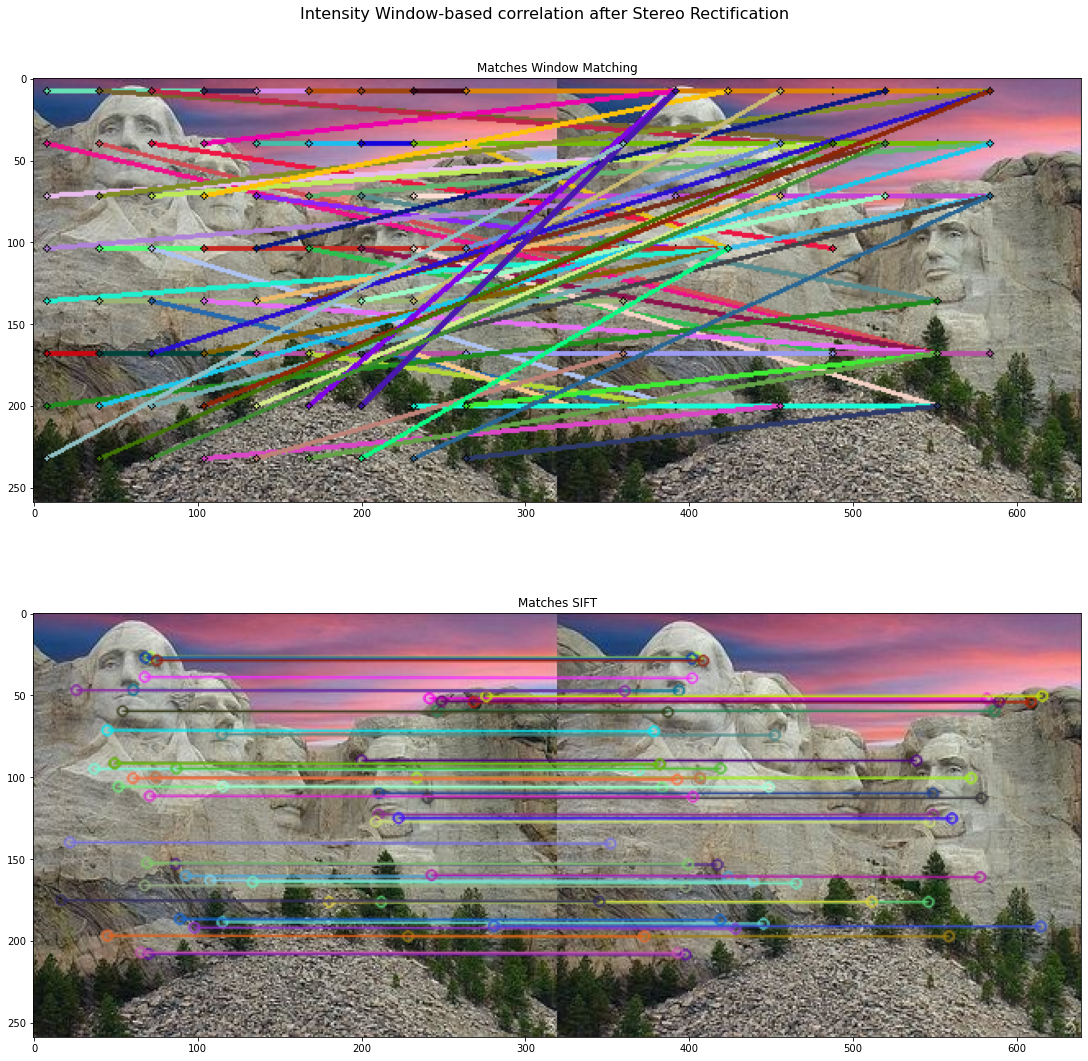

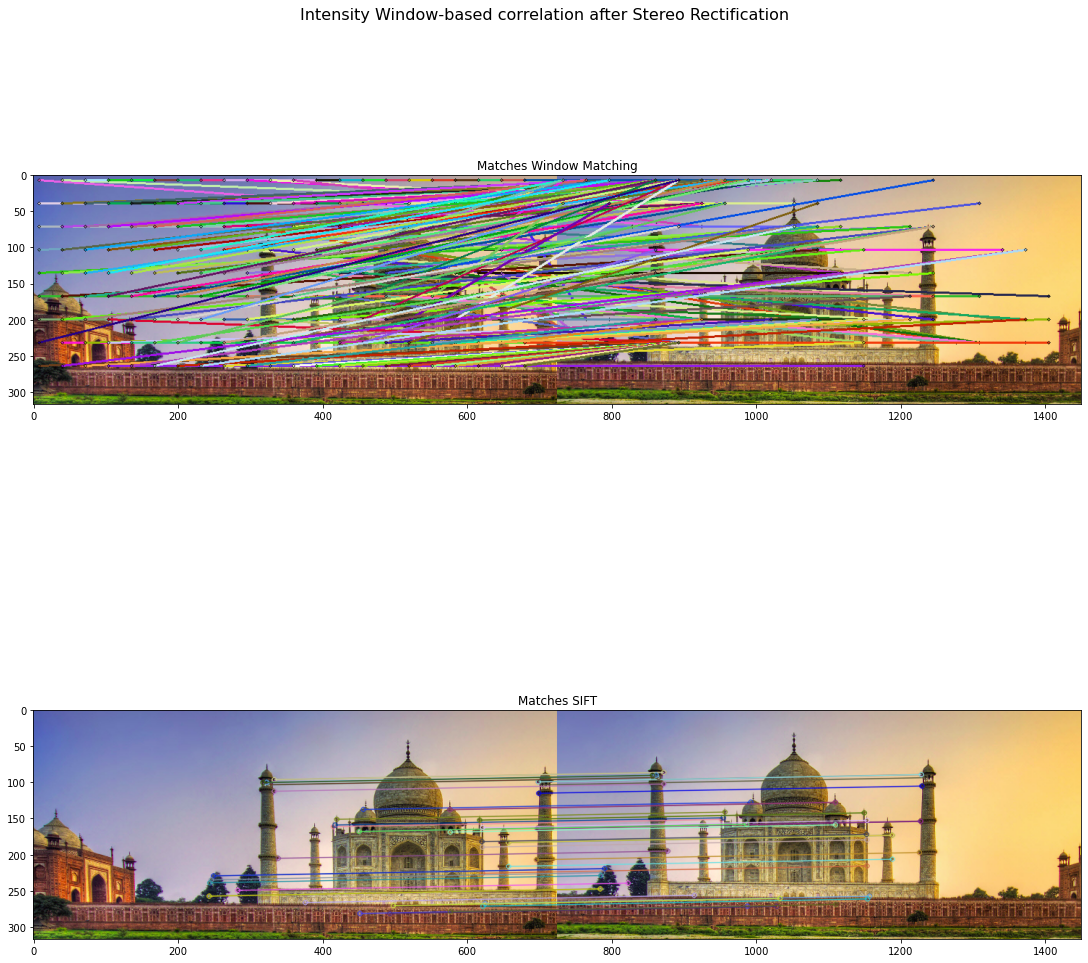

<ipython-input-12-5dc17f872615>:36: RuntimeWarning: invalid value encountered in double_scalars
  n_corr = np.sum(image1*image2) / np.sqrt( np.sum(image1**2) * np.sum(image2**2))


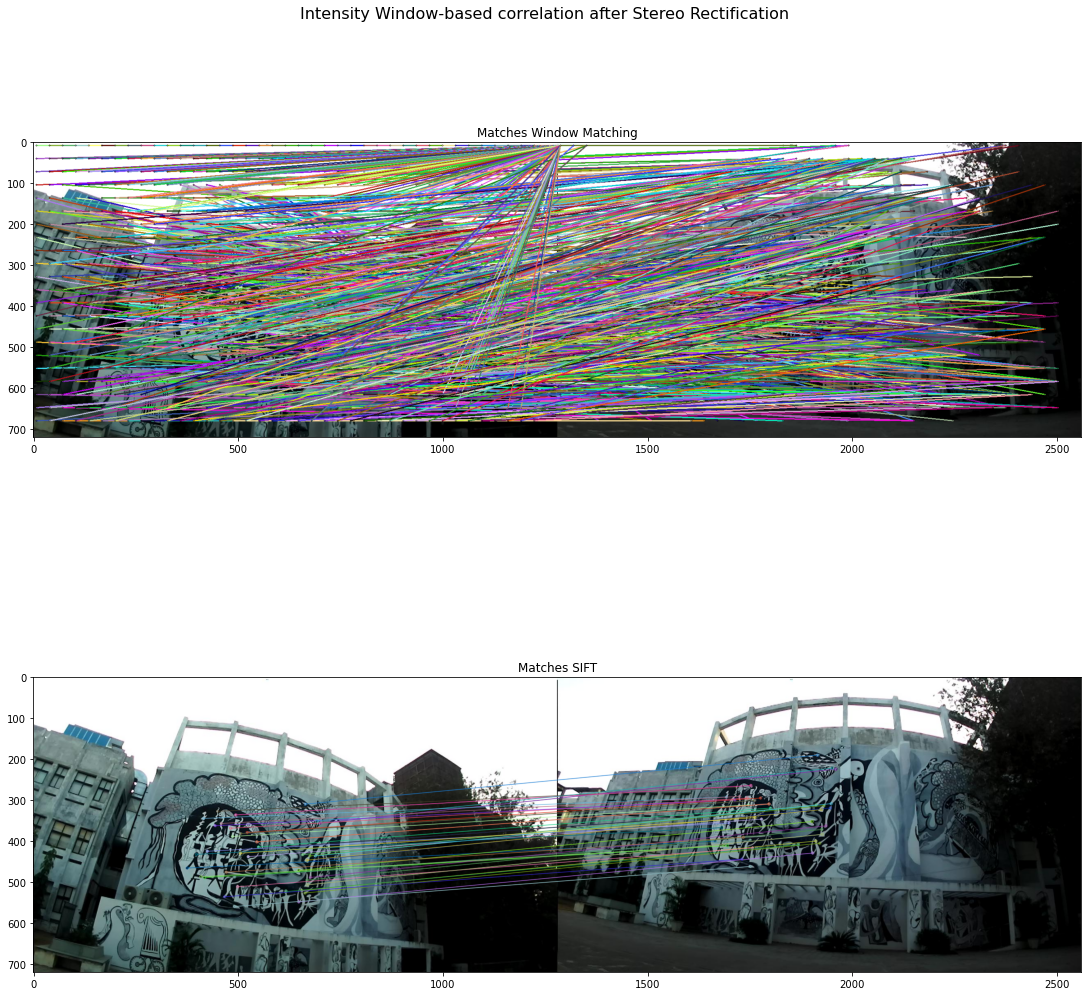

In [36]:
im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/1_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
M4(im,im1,im2)

im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_1.png"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/2_2.png"), cv2.COLOR_BGR2RGB)
cm = cv2.resize(im2, (725, 317), 
               interpolation = cv2.INTER_NEAREST)
im = cv2.hconcat([im1,cm])
M4(im,im1,cm)

im1 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("./images/Stereo Correspondence/3_2.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.hconcat([im1,im2])
M4(im,im1,im2)